In [ ]:
# query strategies impact on datasets

# 1. Build infrastructure
# 2. implement full finetuned LC strategys + MA + EN
# Plot different chosen data examples -> chosen to use powerpoint for illustrative visualization

In [37]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import numpy as np
import spacy
import torch
from numba import jit
import matplotlib.pyplot as plt

In [2]:
input_model = "dxiao/bert-finetuned-ner-100percent"
input_dataset = 'dxiao/requirements-ner-id'

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForTokenClassification.from_pretrained(input_model)
xiao_data = load_dataset(input_dataset)
xiao_data = xiao_data['train']

Using custom data configuration dxiao--requirements-ner-a9d27206730c3bd0
Found cached dataset json (C:/Users/dekai/.cache/huggingface/datasets/dxiao___json/dxiao--requirements-ner-a9d27206730c3bd0/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Generalizable inference
# Input: dataset + inference_model -> Utilizes inference function
# Output: df (incl. predictions)

def general_inference(dataset, inference_model):
    df = dataset.to_pandas()
    df['predictions'] = df['tokens'].apply(lambda x: inference(x.tolist(),inference_model))
    return df

In [4]:
# perform inference on sentences
# Input: word-tokenized sentence as list + model
# Output: predictions [#words, #labels] as np.array

def inference(sentence, inference_model):
    encoding = tokenizer(sentence, return_tensors="pt", truncation=True, is_split_into_words=True) #same params as in evalrun
    outputs = inference_model(**encoding)
    logits = outputs.logits
    predictions = torch.nn.functional.softmax(logits, dim=-1)[0]
    predictions = predictions.detach().numpy()
    return predictions

In [5]:
# Least confidence strategy obtain candidates
# Input: df (incl. predictions) + step_size -> Utilizes least_confidence_calculation function
# Output: candidate_list, non_candidate_list

def LC_candidates(df, step_size):
    df['LC'] = df['predictions'].apply(lambda x: least_confidence_calculation(x))
    df = df.sort_values(by='LC')
    candidate_list = list(df.index[:step_size])
    non_candidate_list = list(df.index[step_size+1:])
    return candidate_list, non_candidate_list

In [6]:
# calculate least confidence score from predictions of one sentence
# Input: predictions in shape [#words, #labels] as np.array
# Output: min margin value 

@jit(nopython=True)

def least_confidence_calculation(predictions):
    least_confidence_list = []
    for word in predictions: # word level
        pred_1st = np.partition(word,-1)[-1] # highest prediction
        least_confidence_list.append(pred_1st)
    return min(least_confidence_list) # minimum prediction of words in sentence is weakest link 

In [11]:
# Entropy strategy obtain candidates
# Input: df (incl. predictions) + step_size -> Utilizes max_entropy_calculation function
# Output: candidate_list, non_candidate_list

def EN_candidates(df, step_size):
    df['entropy'] = df['predictions'].apply(lambda x: max_entropy_calculation(x))
    df = df.sort_values(by='entropy',ascending=False)
    candidate_list = list(df.index[:step_size])
    non_candidate_list = list(df.index[step_size+1:])
    return candidate_list, non_candidate_list

In [12]:
# calculate max entropy score from predictions of one sentence
# Input: predictions in shape [#words, #labels] as np.array
# Output: max entropy value 

@jit(nopython=True)
def max_entropy_calculation(predictions):
    entropy_list = []

    for word in predictions: # word basis
        entropy = 0
        for label_prob in word: #label basis    
            added_entropy = -label_prob*np.log(label_prob)
            entropy += added_entropy
        entropy_list.append(entropy)

    return max(entropy_list)

In [13]:
# Entropy strategy obtain candidates
# Input: df (incl. predictions) + step_size -> Utilizes max_entropy_calculation function
# Output: candidate_list, non_candidate_list

def MA_candidates(df, step_size):
    df['margin'] = df['predictions'].apply(lambda x: margin_calculation(x))
    df = df.sort_values(by='margin')
    candidate_list = list(df.index[:step_size])
    non_candidate_list = list(df.index[step_size+1:])
    return candidate_list, non_candidate_list

In [14]:
# calculate min margin score from predictions of one sentence
# Input: predictions in shape [#words, #labels] as np.array
# Output: min margin value 

@jit(nopython=True)

def margin_calculation(predictions):
    margin_list = []
    for word in predictions: # word level
        pred_1st = np.partition(word,-1)[-1] # highest prediction
        pred_2nd = np.partition(word,-2)[-2] # second-highest prediction
        margin = pred_1st - pred_2nd
        margin_list.append(margin)
    return min(margin_list) # minimum margin of word in sentence is weakest link 

In [9]:
df = general_inference(xiao_data, model)

In [32]:
LC_list, x = LC_candidates(df, 10)
MA_list, x = MA_candidates(df, 10)
EN_list, x = EN_candidates(df, 10)

In [33]:
LC_list.sort()
MA_list.sort()
EN_list.sort()

In [35]:
print(LC_list)
print(MA_list)
print(EN_list)

[4, 27, 46, 183, 212, 280, 440, 481, 509, 614]
[16, 137, 183, 237, 267, 280, 481, 496, 499, 509]
[4, 27, 40, 46, 64, 181, 354, 440, 481, 614]


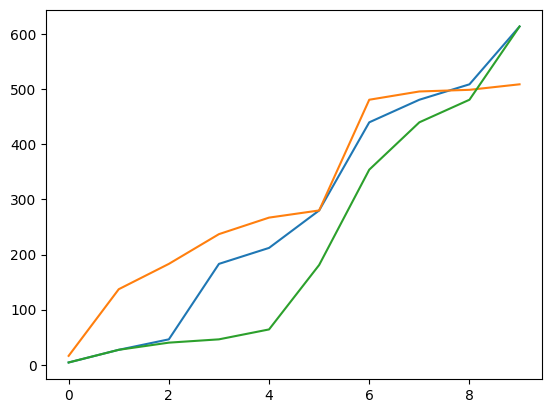

In [39]:
plt.plot(LC_list)
plt.plot(MA_list)
plt.plot(EN_list)